<a href="https://colab.research.google.com/github/alfredoaguiararce/rhonn-module-python/blob/main/examples/Robot_Uniciclo_(RHONN_identifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Robot movil (tipo uniciclo)

## Analisis matematico

En este primer apartado se realiza la implementacion de las formulas en el apartado <em>IV Aplication: A) Electrically Driven Nonholonomic Mobile Robot</em>.

1. Agregamos las librerias necesarias para el analisis matematico.

In [1]:
import numpy as np  #Facilita el manejo de matrices en Python.
import math         #Agregar las funciones trigonometricas a Python.
import matplotlib.pyplot as plt #Agregar libreria para realizar graficas.

2. Definimos algunas funciones que nos permitan no escribir tanto codigo , las funciones implementadas aqui por lo general son segmentos de codigo que se repetian mucho en el codigo, esta es una optimizacion.

In [2]:
# -*- coding: utf-8 -*-
"""
Recurrent High Order Neural Networks (RHONN).
@author: Alfredo Aguiar Arce. <alfredoaguiararce@gmail.com> (www.alfredoagrar.com) 

Module to model neurons based on RHONN model.

Input variable Z     :   Measurements entering the neuron. Z = [ z1, z2, z3 ... zn]
Input variable W     :   Synaptic weight for its respective input Z. W = [w1, w2, w3 ... wn].Transpose
Output prediction    :   The result from the vectorial equation  (Z * W).
state EKF            :   State of the weights (bias) for each input Z.
"""

from abc import ABC, abstractmethod
import numpy as np
import math

class RHONN:
    def __init__(self, weights: int, zinputs: int):
        """
        Creates a neuron object based on RHONN.
        Inputs
        :param  : weights   : The array that contains initial values of the weights. W = [w1, w2, w3 ... wn]
        :param  : zinputs   : The array that contains signals or inputs for the neuron. Z = [ z1, z2, z3 ... zn]      
        """
        # Probe if W and Z has not the same number of elements in array.
        if np.size(weights) != np.size(zinputs):
            # The dimensions of weights and zinputs are diferents, raise an error. the size of W and Z need to be equals.
            raise ValueError("The dimensions of the vectors must be equal; size(weights) != size(zinputs)")
        
        # (int) number used for control of dimensions.
        self.size_input = np.size(zinputs)
        self.weights = np.array([weights]).T
        self.zinputs = np.array([zinputs])
        # init the ekf for the neuron
        self.ekf = EKF(self.weights, self.zinputs)
        # init the prediction as 0.
        self.prediction = 0

    def set_ekf(self, P_init : float =0.001, Q_init : float =0.001, R_init : float =0.001, FO: float=1):
        """
        Init the Extended Kalman Filter.
        Inputs
        :param  : P_init  : initial value for P matrix in the EKF.
        :param  : Q_init  : initial value for Q matrix in the EKF.
        :param  : R_init  : initial value for R in the EKF.
        :param  : FO      : Forgetting factor FO used to adjust the reaction to sudden changes in the forecast, if FO = 1 the EKFFO results must be equal to normal EKF.
        """
        self.ekf.init_filter(self.size_input, P_init, Q_init, R_init, FO)

    def update(self, new_zinputs, measure_signal):
        """
        Update the Extended Kalman Filter value in k-th
        Inputs
        :param  : new_zinputs     : The measurements of the inputs in the step k-th.
        :param  : measure_signal  : The value to predict. Used for calculate the error.
        """
        
        # Update the error by passing the measure value, and the previus value of prediction.
        self.ekf.set_error(measure_signal, self.predict())

        # check if are the same dimension from the (k - 1) iteration.
        # The size of the new z inputs dimensions, are different in this iteration.
        if np.size(new_zinputs) != np.size(self.zinputs):
            raise ValueError("The dimensions of the vector Z are diferent in this iteration.")
        self.zinputs = np.array([new_zinputs])
        self.weights = self.ekf.update_weights(self.zinputs)            
            
    
    def predict(self):
        """
        Calculate the value of the neuron in (k + 1)
        Return:
        :param : prediction : Numpy vectorial dot product of equation Z * W.
        """
        self.prediction = np.dot(self.zinputs, self.weights)
        return self.prediction

class EKF: 
    """
    - NOTES - In this case for Extended Kalman Filter W, H, P, R, Q represent the values of k-th
    Wk, Pk represent the values of k + 1 : 

    - Li - is the total number of weights (w11,w12 ... wn)
    - m -  the total number of outputs in this case equals to 1 (X(k+1))
 
    - H - is a matrix  Li x m  
    - K - is a matrix  Li x m   
    - M - is a matrix  m  x m
    - P - is a matrix  Li x Li 
    - Q - is a matrix  Li x Li 
    - R - is a matrix  m  x m   
    - W - is a vector of Li elements Li x 1 (weights)

    - FO - is the forgettering factor if FO = 1 The model FKEFO transforms in a normal form of FKE.
    """

    def __init__(self, weights, H, FO=1):
        """
        Initialize the Extended Kalman Filter for the i-th neuron.
        Inputs
        :param  : weights   : Numpy array of actual vector W in the object rhonn.
        :param  : H         : Input vector used for the system linearizations.
        :param  : FO        : Forgetting factor, default is 1.
        """
        if np.size(weights) != np.size(H) or np.size(weights) <= 0:
            raise ValueError("Invalid dimensions for weights and H")

        self.Li = np.size(weights)
        self.m = 1
        self.H = H
        self.K = np.array(np.zeros((self.Li, self.m)))
        self.M = np.array(np.zeros((self.m, self.m)))
        self.P = np.array(np.zeros((self.Li, self.Li)))
        self.Q = np.array(np.zeros((self.Li, self.Li)))
        self.R = np.array(np.zeros((self.m, self.m)))
        self.W = weights
        self.error = 0
        self.fo = FO

    def init_filter(self, size_input: int, P_init, Q_init, R_init, FO):
        # Initialize EKF parameters
        # Declare an array of [0... n] elements where, each element are equal to init values.
        parray = np.array([P_init for x in range(0, size_input)])
        qarray = np.array([Q_init for x in range(0, size_input)])
        rarray = np.array([R_init])

        # P, Q, R must be diagonal matrix.
        P0 = np.diag(parray) 
        Q0 = np.diag(qarray) 
        R0 = np.diag(rarray)

        # init the paramethers in extended kalman filter (EKF) object.
        self.set_P(P0)
        self.set_Q(Q0)
        self.set_R(R0)
        self.set_FO(FO)

    def update_weights(self, H):
        """
        Update the values of bias W
        Inputs
        :param  : H : The vector H used for reference the linealitations of the system, in the k-th iteration. 

        Return:
        :param  : W : the ajust of the W vector as a new value of W. 

        """      
        # Declare the new value of H  
        self.H = H

        # M(k) = R * FO + H * P * H.T
        self.M = np.dot(self.R, self.fo) + (np.dot(self.H, np.dot(self.P, self.H.T)))

        num_rows, num_cols = self.M.shape
        if (num_rows == self.m) and (num_cols == self.m):
            # K(k) = (P * H.T) / M
            self.K = np.divide(np.dot(self.P, self.H.T), (self.M))
        else:
            raise ValueError('something happend M', num_rows, num_cols)


        num_rows, num_cols = self.K.shape
        if (num_rows == self.Li) and (num_cols == self.m):
            # W(k+1) = W(k) + K * error
            # wk is the actual value of W before the ejecution W(k)
            wk = self.W
            self.W = wk + (np.dot(self.K, self.error))
        else:
            raise ValueError('something happend K')


        # P(k+1) = P(K) * FO - (K * FO * H * P(k)) + Q
        # pk is the actual value of P before the ejecution P(k).
        pk = self.P
        self.P = (np.dot(pk, 1 / self.fo)) - (np.dot( np.dot(self.K, 1/ self.fo), np.dot(self.H, pk))) + self.Q

        # Return the estimation of W.
        return self.W

    def set_error(self, measure, estimation):
        """
        Track the error for the signal.
        Inputs
        :param  : measure     : It is the follow-up of the signal that you want to predict
        :param  : estimation  : Is the previous prediction of X(k + 1)
        """
        self.error = measure -  estimation

    # Def getters and setters for the variables of EKF
    def set_FO(self, FO):
        self.fo = FO
        
    def set_H(self, H):
        self.H = H

    def get_H(self):
        return self.H 
    
    def set_K(self, K):
        self.K = K

    def get_K(self):
        return self.K

    def set_M(self, M):
        self.M = M

    def get_M(self):
        return self.M

    def set_P(self, P):
        self.P = P

    def get_P(self):
        return self.P
    
    def set_Q(self, Q):
        self.Q = Q

    def get_Q(self):
        return self.Q

    def set_R(self, R):
        self.R = R

    def get_R(self):
        return self.R
    
    def set_W(self, W):
        self.W = W

    def get_W(self):
        return self.W



# The class ActivationFunction is an abstract base class that defines a method activate().
class ActivationFunction(ABC):
    @abstractmethod
    def activate(self, c):
        pass

class SoftSigmoid(ActivationFunction):
    def activate(self, c, B=0.83):
        """
        Activation function soft sigmoidal.
        Inputs
        :param  : c    : Value of the signal in k-th
        :param  : B    : Beta used for the adjustment of the sigmoidal.

        Return:
        Result of the operation 1/(1 + e^(-B * C)) 
        """
        return 1 / (1 + math.exp(-B * c))


class activation:
    """ This class defines the activation functions."""

    def soft_sigmoid(c, B = 0.83):
        """
        Activation function soft sigmoidal.
        Inputs
        :param  : c    : Value of the signal in k-th
        :param  : B    : Betha used for the ajust of the sigmoidal.

        Return:
        Result of the operation 1/(1 + e^(-B * C)) 

        """
        return 1 / (1 + math.exp(-B * c))

# TODO: add more activation functions

In [3]:
def diag(a11, a22):
  """
    Esta funcion regresa una matriz diagonal.
    La matriz se define como :
    [a11 0]
    [0 a22]
  """
  return np.array([[2.5, 0], [0, 2.5]])

def scope(data, x_label = 'x_label', y_label = 'y_label'):
  """
    Esta funcion regresa una grafica sencilla de los datos enviados a travez de 'data'
    por lo tanto data = a un areglo.
    Repreesenta una funcion similar al bloque scope.
  """
  plt.plot(data)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  return plt

def graph_xy(data_x, data_y, x_label = 'x_label', y_label = 'y_label', subtitle = 'subtitle'):
  """
    Esta funcion muestra una grafica sencilla en el plano cartesiano XY
  """
  plt.plot(data_x, data_y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.suptitle('Posiciones de subsitema X1 matriz Jacobiana Jx1')
  return plt

In [4]:
#Ejemplo implementacion de la funcion diag
ejem_1 = diag(2.5,2.5)
#Imprimimos valor e informacion


3. Definicion de variables del sistema

In [5]:
#Constantes iniciales
#La mitad del ancho del robot mobil.
R = 0.75
#La distancia del centro de Pc del robot mobil a la mitad del punto medio de P0 en medio de las ruedas izquierda y derecha.
d = 0.3
#Radio de la rueda.
r = 0.15
#Masa del cuerpo.
mc = 30
#Masa de la rueda con motor.
mw = 1
#Ic,Iw,Im son los momentos de inercia del cuerpo sobre el eje vertical a traves de Pc.
Ic = 15.625
Iw = 0.005
Im = 0.0025
#Resistencia.
Ra = diag(2.5,2.5)
#Inductancia.
La = diag(0.048,0.048)
#Coeficiente de fuera electromotriz trasero.
KE = diag(0.02,0.02)
#Relacion de transmision.
N = diag(62.55,62.55)
#Constante de torque del motor.
KT = diag(0.2613,0.2613)
#dm1, dm2 son los coeficientes de amortiguamiento.
dm1 = 0.5
dm2 = dm1
D = diag(dm1, dm2)

# Constantes productos de otras constantes%%%%%%%%%%%%%%%%%%%%
m = mc + (2 * mw)
I = (mc * (d ** 2)) + (2 * mw * (R**2)) + Ic + (2*Im)
m11 = 0.25 * ( R ** -2 ) * (r ** 2) * ((m * (R ** 2)) + I) + Iw
m12 = 0.25 * ( R ** -2 ) * (r ** 2) * ((m * (R ** 2)) - I)
M = np.array([[m11, m12], [m12, m11]])

### Configuracion de muestreo

En este apartado se configuran las variables para realizar la simulacion donde:

* tf =  El tiempo total en segundos que dura la simulacion.
* ts = Es el muestreo, o el tiempo en segundos que durara 1 muestra.
* N = El total de muestras existentes de valor ts a lo largo del tiempo tf.
* t = Es un arreglo de tiempo que contiene los segundos para n-esima muestra 

<em>Ejemplo de como se encuentra formado 't'

Para : 
* tf = 180
* ts = 0.2 </em>
* Por lo tanto numero de muestras = (180 / 0.2) = 900 


| No de muestra     | segundos (s) |
| -----------       | ----------- |
| 0                 | 0           |
| 1                 | 0.2         |
| 2                 | 0.4         |
| ...                 | ...        |
| 900                 | 180        |

In [6]:
#Parametros para configurar el tiempo de muestreo en la simulacion asi como los intervalos en los que se realiza.

tf = 180           # Tiempo de simulacion en segundos (s)
ts = 0.2           # Periodo de muestreo en segundos (s)
N = int(180/0.2) #El numero total de muestras
t = np.linspace(0, tf, N)      # Vector de tiempo 0, 0.2, 0.4...

### Simulacion

In [7]:
#del x, y, phi, x11_prediction, x12_prediction, x13_prediction, xp, yp, theta, v1, v2, neurona_X1, neurona_X2, neurona_X3
# Posiciones
xp = [0]
yp = [0]
theta = [0]

# Velocidades
# Velocidad Lineal de la rueda Derecha.
v1_scalar = 0.1;    # m/s
v1 = v1_scalar * np.ones(N)

# Velocidad Lineal de la rueda Izquierda. 
v2_scalar = -0.2    # m/s
v2 = v2_scalar * np.ones(N)

# inicializamos las neuronas X1, X2, X3 Donde:
# X1 = posicion X(k + 1)
# X2 = posicion Y(k + 1)
# X3 = posicion angulo del robot(K + 1)

# Parametros iniciales de las Neuronas.
# Se inicializan los vectores Z y W iniciales para cada neurona
# se debe considerar que Z y W deben tener una longitud igual, o saltara un mensaje de error de parte de la liberia rhonn.

# Especificamente Z representas las entradas iniciales que toma la neurona 
# en este caso Z = [a1, a2]; donde a1 = posicion X inicial, a2 = posicion Y inicial.
Z1 = [0 ,0]
Z2 = [0 ,0]
Z3 = [0 ,0]
# Asi mismo dado la estructura que sigue el algoritmo debe haber 'n' pesos por cada entrada
# siendo este caso W = [w11, w12]
W1 = [0, 0]
W2 = [0, 0]
W3 = [0, 0]

#Los parametros con los que deseamos inicializar el filtro extendido de kalman para cada neurona:
# EKF para X1
P1 = 1 * (10**8)
Q1 = 1 * (10**4)
R1 = 5 * (10**5)

# EKF para X2
P2 = 1 * (10**2)
Q2 = 5 * (10**4)
R2 = 5 * (10**5)

# EKF para X3
P3 = 1 * (10**8)
Q3 = 1 * (10**4)
R3 = 5 * (10**5)

# Definimos los objetos que hacen referencia a las neuronas de la RHONN, 
# se crea una instancia que referencia al objeto, a la cual debemos pasarles sus valores iniciales de W y Z
neurona_X1 =  RHONN(W1, Z1)
# Por defecto si no llamos la funcion '.set_ekf()' automaticamente inicializara los valores iniciales en 0.01
# NOTA: es recomendable modificar estos parametros P,Q,R de manera hueristica.
# En este caso en especifico 0.5 representa el Factor de olvido para un filtro extendido de kalman con factor de olvido, 
# cuando se omite este parametro el factor de olvido se inicializa como 1, de manera que funciona como un filtro extendido de kalman normal.
neurona_X1.set_ekf(P1, Q1, R1, 0.5) 


neurona_X2 = RHONN(W2, Z2)
neurona_X2.set_ekf(P2, Q2, R2)

neurona_X3 = RHONN(W3, Z3)
neurona_X3.set_ekf(P3, Q3, R3)

x = [0]
y = [0]
phi = [0]

x11_prediction = [0]
x12_prediction = [0]
x13_prediction = [0]

for k in  range(N - 1):
    
   
    
    #Vector de Posiciones X1 : >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    positions_array = [[x[k]],[y[k]],[phi[k]]]
    X1 = np.array(positions_array)

    #Vector velocidades X2 en el instante de tiempo k-esimo.>>>>>>>>>>>>>>>>>>>>>>>>>>
    x_21 = v1[k]
    x_22 = v2[k]
    velocity_array = [[x_21],[x_22]]
    #Vector de las velocidades x2 :
    #v1 = Velocidad angular izquierda, 
    #v2 = Velocidad angular derecha.
    X2 = np.array(velocity_array)

    #Matriz Jacobiana J(x1)
    J_x1 = 0.5 * r * np.array([[math.cos(phi[k]), math.cos(phi[k])], [math.sin(phi[k]), math.sin(phi[k])],  [1/R, -1/R]])
    
    #Ecuacion de sub sistema 1. (Modelo cinematico)
    EQ = np.dot(J_x1,X2)

    """
    Integral numerica (Metodo Euler)
    A continuacion se realizan las iteraciones por el metodo de Euler para
    obtener la posicion en el siguiente instante de tiempo.
    Esto se fundamenta dado que la matriz jacobiana por el vector de
    velocidad representan la ecuacion cinematica.
    En resumen al integrar la velocidad podemos encontrar la posicion.
    """
    x.append(x[k]+ts*EQ[0])
    y.append(y[k]+ts*EQ[1])
    phi.append(phi[k]+ts*EQ[2])
    
     # S(x11) , S(x12)
    entradas = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X1.update(entradas, x[k])
    # S(x11) , S(x12)
    entradas2 = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X2.update(entradas2, y[k])
    # S(x11) , S(x12)
    entradas3 = [activation.soft_sigmoid(x[k]), activation.soft_sigmoid(y[k])]
    neurona_X3.update(entradas3, phi[k])
    
    
    x11_prediction.append(neurona_X1.predict())
    x12_prediction.append(neurona_X2.predict())
    x13_prediction.append(neurona_X3.predict())
    


C:\Users\alfre\AppData\Local\Temp\ipykernel_31720\3879211020.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_x1 = 0.5 * r * np.array([[math.cos(phi[k]), math.cos(phi[k])], [math.sin(phi[k]), math.sin(phi[k])],  [1/R, -1/R]])
C:\Users\alfre\AppData\Local\Temp\ipykernel_31720\1995374049.py:272: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-B * c))


In [10]:
print(len(t))

900


In [11]:
print(len(x))

900


In [12]:
print(len(x11_prediction))

900


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (900,) + inhomogeneous part.

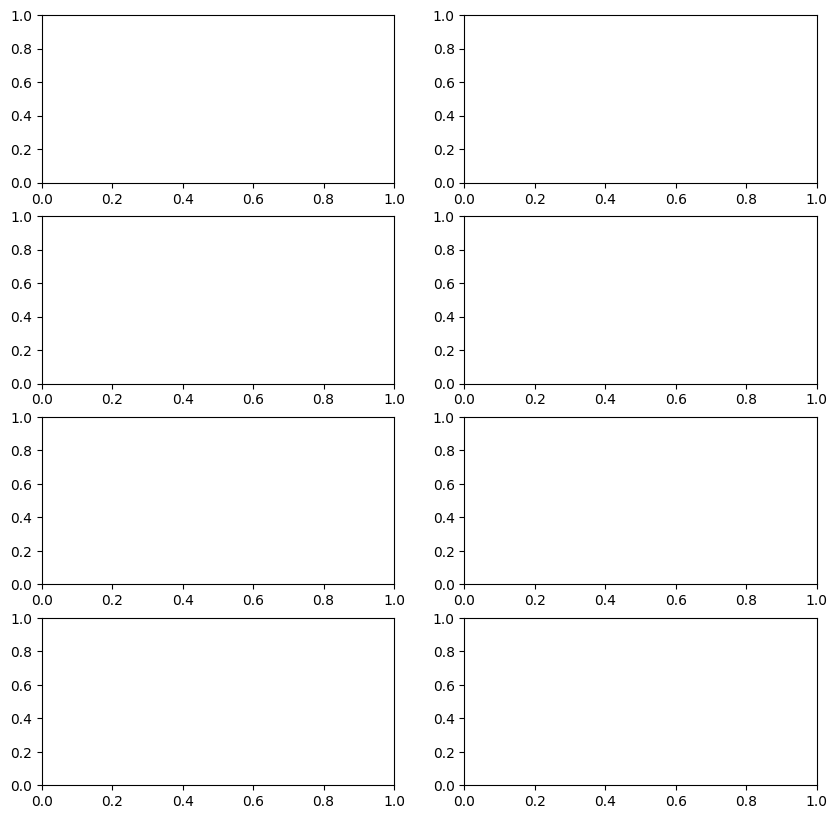

In [13]:
# Inicializamos la grafica
dim_img = 10
plt.rcParams["figure.figsize"] = (dim_img,dim_img)
figure, axis = plt.subplots(4, 2)
  
# Para la grafica de la posicion X
axis[0, 0].plot(t,x)
axis[0, 0].set_title("Position X (MODELO CINEMATICO)")
  
axis[0, 1].plot(t, x11_prediction)
axis[0, 1].set_title("Position X (RHONN)")
  
# Para la grafica de la posicion Y
axis[1, 0].plot(t, y)
axis[1, 0].set_title("Position Y (MODELO CINEMATICO)")
  
axis[1, 1].plot(t, x12_prediction)
axis[1, 1].set_title("Position Y (RHONN)")
   
# Para la grafica de la posicion phi
axis[2, 0].plot(t, phi)
axis[2, 0].set_title("Position phi (MODELO CINEMATICO)")
  
axis[2, 1].plot(t, x13_prediction)
axis[2, 1].set_title("Position phi (RHONN)") 

# Para la grafica de la posicion XY
axis[3, 0].plot(x, y)
axis[3, 0].set_title("Position xy (MODELO CINEMATICO)")
  
axis[3, 1].plot(x11_prediction, x12_prediction)
axis[3, 1].set_title("Position phi (RHONN)")
  
# Combine all the operations and display
plt.show()

## Graficas sobre puestas 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (900,) + inhomogeneous part.

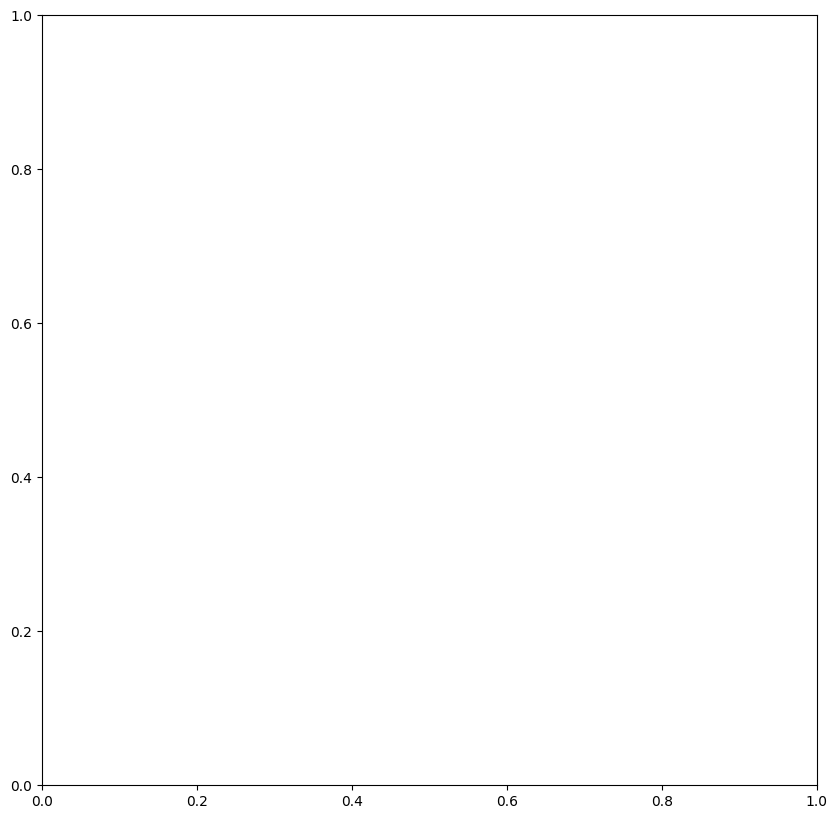

In [14]:
# Posicion en X con 
plt.plot(t, x, 'r') # Posicion en X por modelo cinematico
plt.plot(t, x11_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN con Factor de olvido 0.5

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


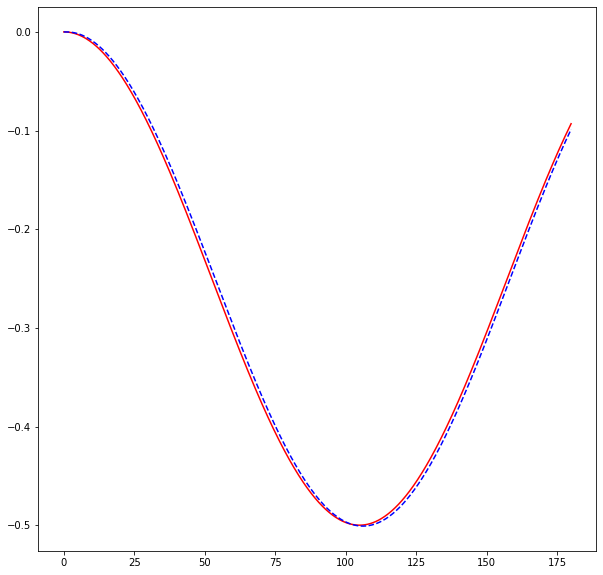

In [ ]:
# Posicion en Y con 
plt.plot(t, y, 'r') # Posicion en Y por modelo cinematico
plt.plot(t, x12_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN sin Factor de olvido

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


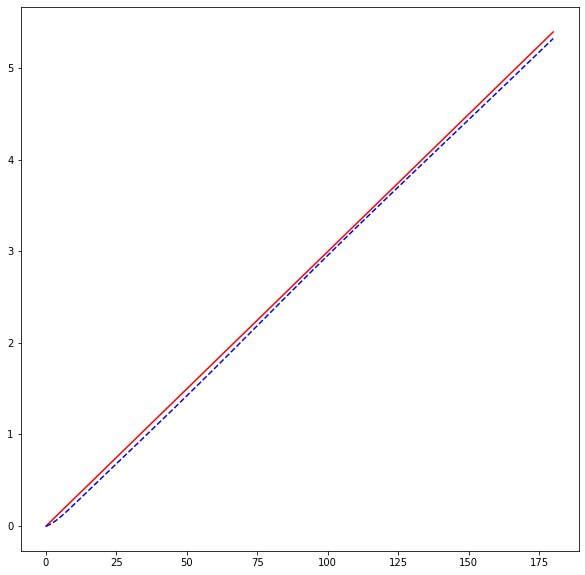

In [ ]:
# Posicion en Phi con 
plt.plot(t, phi, 'r') # Posicion en Phi por modelo cinematico
plt.plot(t, x13_prediction, 'b', linestyle='dashed') # Posicion en Phi por RHONN sin Factor de olvido

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


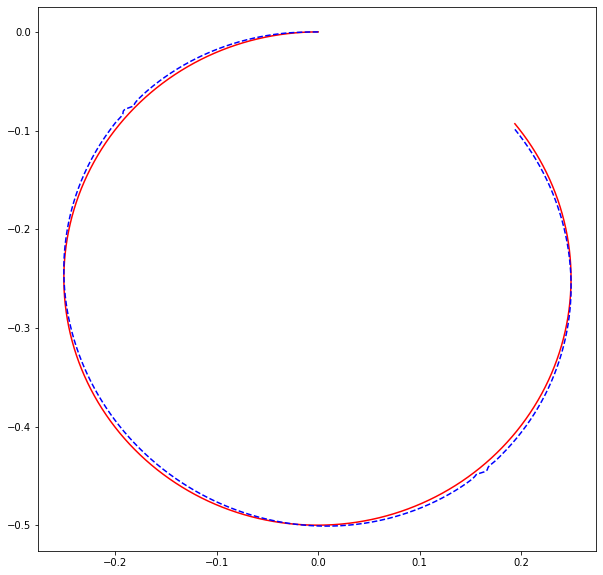

In [ ]:
# Posicion en X con 
plt.plot(x, y, 'r') # Posicion en Y por modelo cinematico
plt.plot(x11_prediction, x12_prediction, 'b', linestyle='dashed') # Posicion en X por RHONN sin Factor de olvido